<a href="https://colab.research.google.com/github/NilayN7/Deep-Learning-Labs/blob/main/2019UEE0112_UNet_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteM1E7VY/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteM1E7VY/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


## Resize the images and masks to 128x128 

In [ ]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

   return input_image, input_mask

## Create a function to augment the dataset by flipping them horizontally

In [ ]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

## Function to normalize the dataset by scaling the images to the range of [-1, 1] and decreasing the image mask by 1

In [ ]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [ ]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

 ## Build an input pipeline with tf.data by using the map() function

In [ ]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

In [ ]:
print(next(iter(train_batches))[0][45])

tf.Tensor(
[[[0.11372549 0.13333334 0.05490196]
  [0.20392157 0.14901961 0.10588235]
  [0.2509804  0.27058825 0.18431373]
  ...
  [0.3372549  0.3254902  0.2901961 ]
  [0.2509804  0.22745098 0.16470589]
  [0.18039216 0.18039216 0.1882353 ]]

 [[0.10588235 0.10588235 0.06666667]
  [0.18039216 0.18039216 0.13333334]
  [0.23921569 0.2627451  0.15294118]
  ...
  [0.15686275 0.16078432 0.14117648]
  [0.1882353  0.1882353  0.18039216]
  [0.11764706 0.12156863 0.13725491]]

 [[0.1764706  0.13333334 0.10980392]
  [0.22745098 0.2        0.1254902 ]
  [0.29411766 0.34509805 0.23529412]
  ...
  [0.10588235 0.15686275 0.12156863]
  [0.16470589 0.16470589 0.17254902]
  [0.14117648 0.14901961 0.14509805]]

 ...

 [[0.05098039 0.06666667 0.0627451 ]
  [0.08235294 0.09019608 0.08627451]
  [0.07843138 0.07843138 0.07058824]
  ...
  [0.67058825 0.6509804  0.63529414]
  [0.6862745  0.68235296 0.6666667 ]
  [0.67058825 0.67058825 0.6627451 ]]

 [[0.05882353 0.07843138 0.0627451 ]
  [0.03921569 0.05882353 0

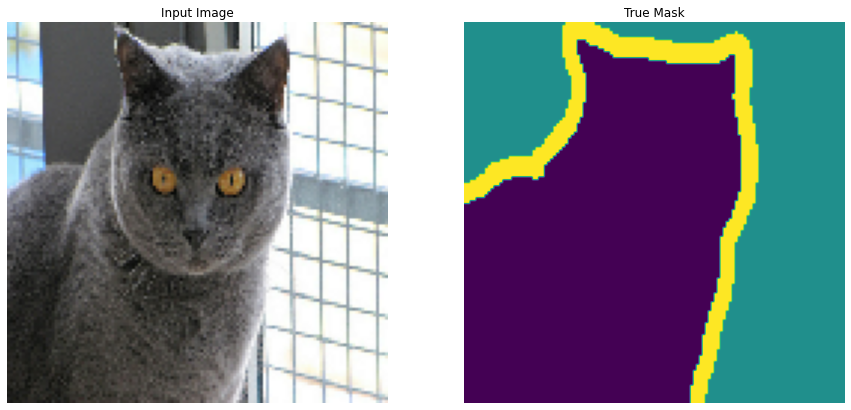

In [ ]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

# Model Architecture

In [ ]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

## U-Net Model

In [ ]:
def build_unet_model():
 # inputs
   inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
layer_ind = []
for i in range(len(unet_model.layers)):
	layer = unet_model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	layer_ind.append(i) 

In [ ]:
layer_names = []
for i in range(len(unet_model.layers)):
	layer = unet_model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	layer_names.append(layer.name) 

In [ ]:
print(layer_names)

['conv2d', 'conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5', 'conv2d_6', 'conv2d_7', 'conv2d_8', 'conv2d_9', 'conv2d_transpose', 'conv2d_10', 'conv2d_11', 'conv2d_transpose_1', 'conv2d_12', 'conv2d_13', 'conv2d_transpose_2', 'conv2d_14', 'conv2d_15', 'conv2d_transpose_3', 'conv2d_16', 'conv2d_17', 'conv2d_18']


In [ ]:
print(layer_ind[2])

5


(128, 128, 3)
1/1 [==============================] - 0s 250ms/step
(1, 128, 128, 3)


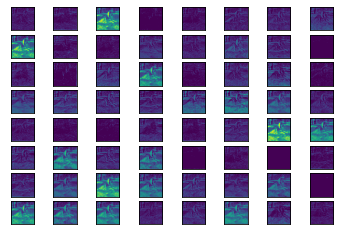

layer:  conv2d


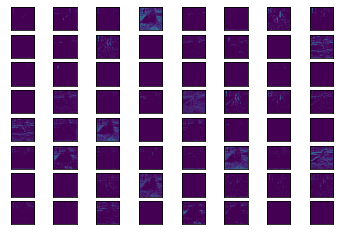

layer:  conv2d_1


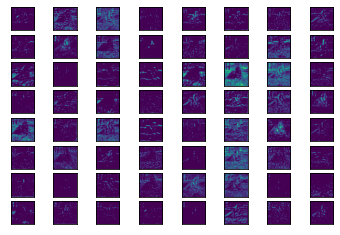

layer:  conv2d_2


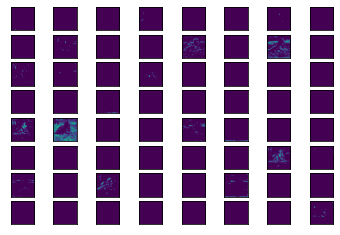

layer:  conv2d_3


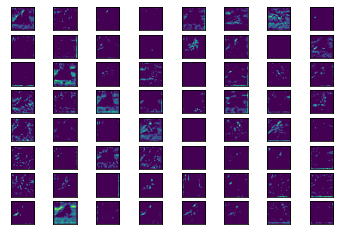

layer:  conv2d_4


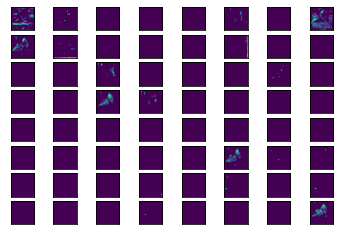

layer:  conv2d_5


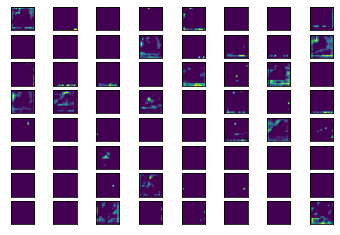

layer:  conv2d_6


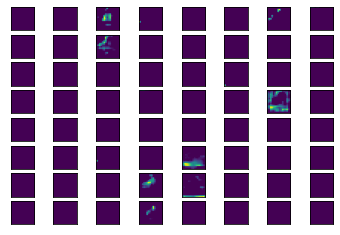

layer:  conv2d_7


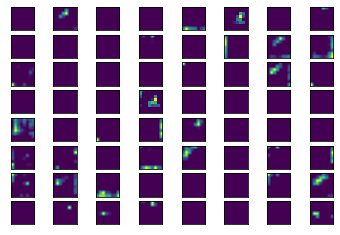

layer:  conv2d_8


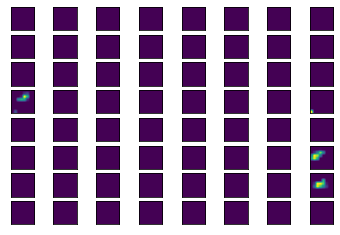

layer:  conv2d_9


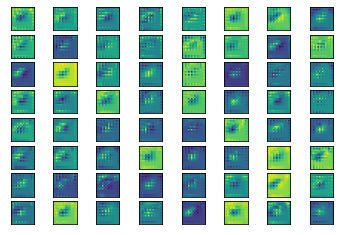

layer:  conv2d_transpose


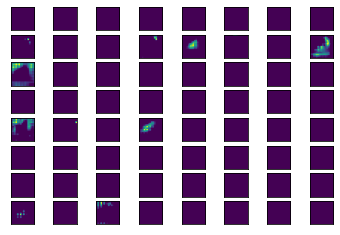

layer:  conv2d_10


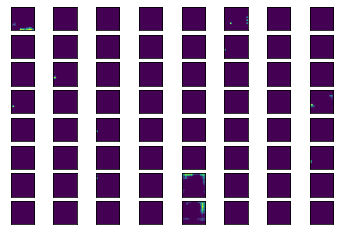

layer:  conv2d_11


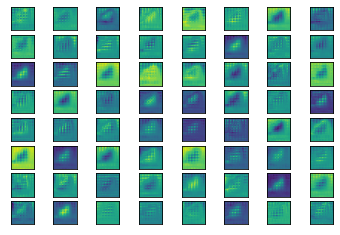

layer:  conv2d_transpose_1


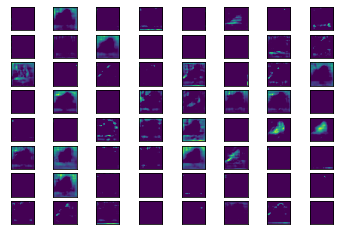

layer:  conv2d_12


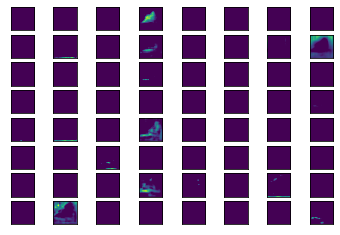

layer:  conv2d_13


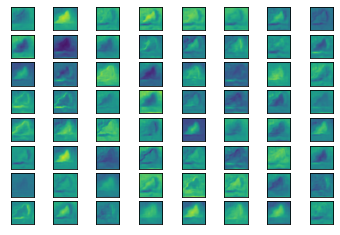

layer:  conv2d_transpose_2


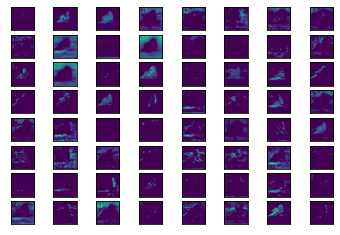

layer:  conv2d_14


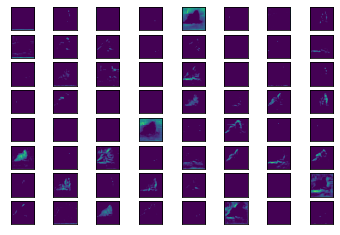

layer:  conv2d_15


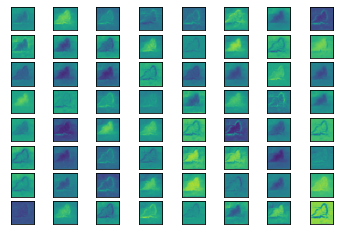

layer:  conv2d_transpose_3


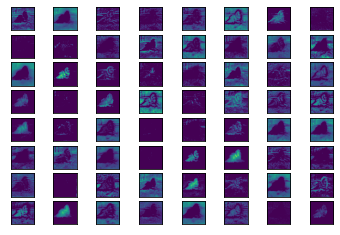

layer:  conv2d_16


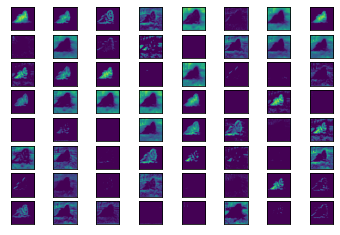

layer:  conv2d_17
final outupt: 


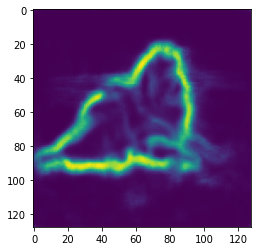

In [ ]:
outputs = [unet_model.layers[i].output for i in layer_ind]
ind = [i for i in layer_ind]
model = tf.keras.Model(inputs=unet_model.inputs, outputs=outputs)
# img = load_img('bird.jpg', target_size=(224, 224))
# img = img_to_array(img)
# img = expand_dims(img, axis=0)
# img = preprocess_input(img)
img = next(iter(train_batches))[0][45]
print(img.shape)
feature_maps = model.predict(tf.expand_dims(img,0))
print(feature_maps[22].shape)
square = 8
for i, fmap in enumerate(feature_maps):
  ix = 1
  if i!=22:
    for _ in range(square):
      for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(fmap[0, :, :, ix-1])
        ix = ix + 1
    plt.show()
    print('layer: ', layer_names[i])
  else:
    print('final outupt: ')
    plt.imshow(fmap[0, :, :, 2])
    plt.show()

# Illustrative Example of U Net Architecture (different from our coded model)

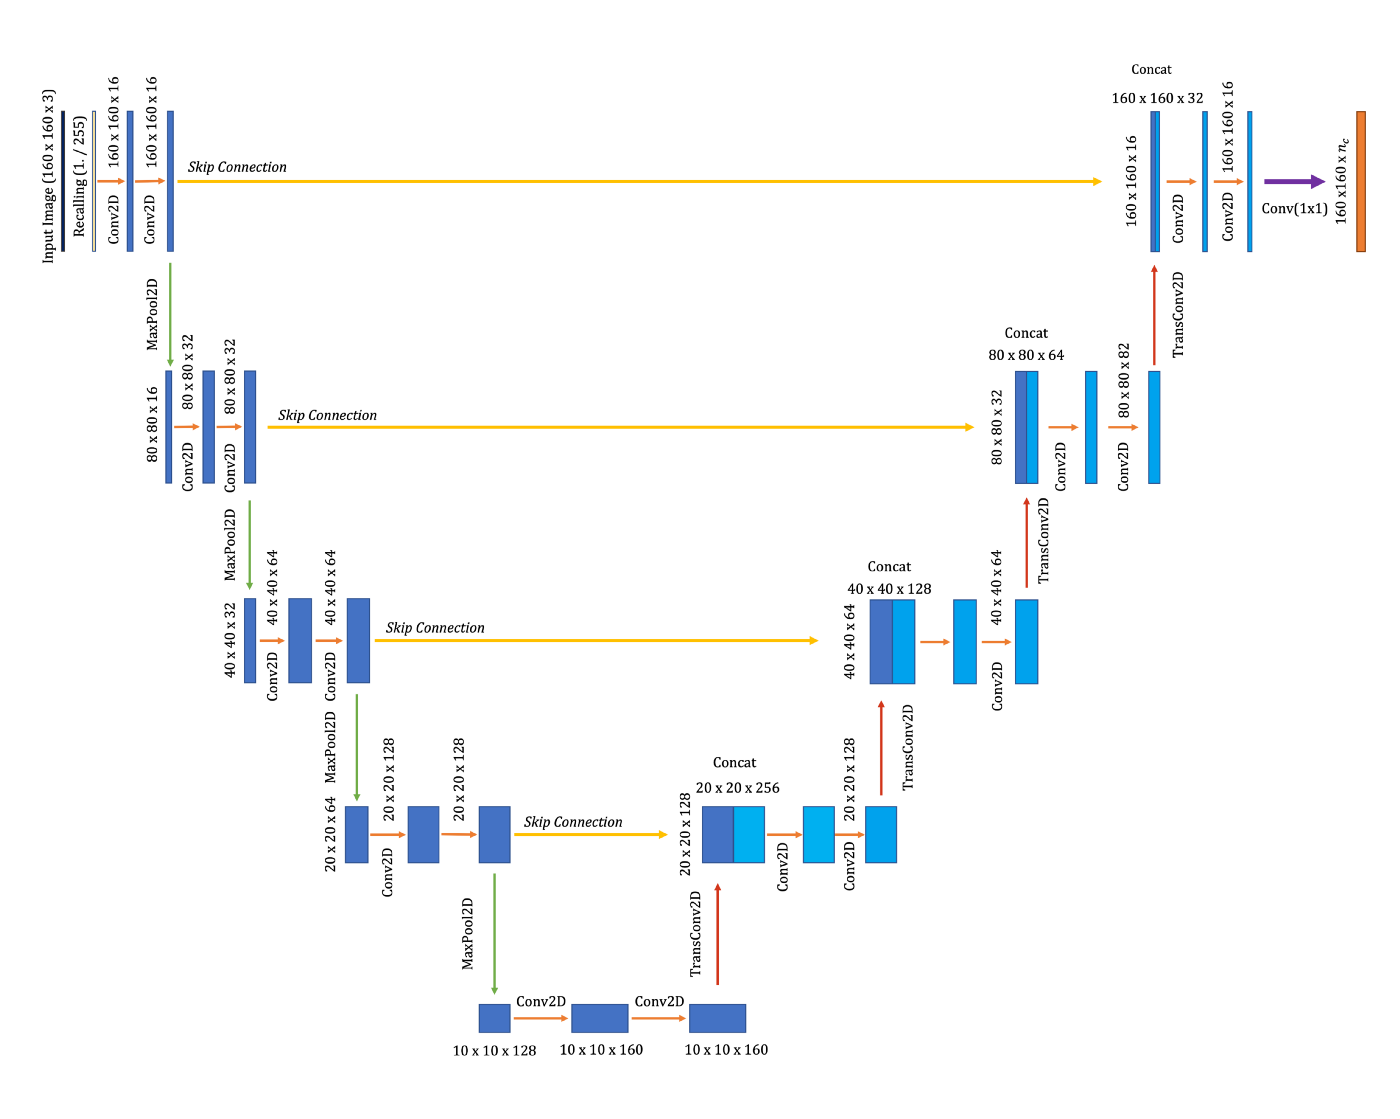

## Compile and Tain model

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [ ]:
NUM_EPOCHS = 10

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/10
57/57 [==============================] - 89s 1s/step - loss: 0.8739 - accuracy: 0.5941 - val_loss: 0.7807 - val_accuracy: 0.6131
Epoch 2/10
57/57 [==============================] - 68s 1s/step - loss: 0.7246 - accuracy: 0.6922 - val_loss: 0.6615 - val_accuracy: 0.7329
Epoch 3/10
57/57 [==============================] - 66s 1s/step - loss: 0.6249 - accuracy: 0.7481 - val_loss: 0.5944 - val_accuracy: 0.7611
Epoch 4/10
57/57 [==============================] - 62s 1s/step - loss: 0.5499 - accuracy: 0.7843 - val_loss: 0.5386 - val_accuracy: 0.7866
Epoch 5/10
57/57 [==============================] - 62s 1s/step - loss: 0.5049 - accuracy: 0.8038 - val_loss: 0.4585 - val_accuracy: 0.8237
Epoch 6/10
57/57 [==============================] - 62s 1s/step - loss: 0.4716 - accuracy: 0.8175 - val_loss: 0.4176 - val_accuracy: 0.8392
Epoch 7/10
57/57 [==============================] - 65s 1s/step - loss: 0.4419 - accuracy: 0.8290 - val_loss: 0.4099 - val_accuracy: 0.8427
Epoch 8/10
57/57 [==

In [ ]:
## Predictions

number of batches: 11
1/1 [==============================] - 0s 232ms/step


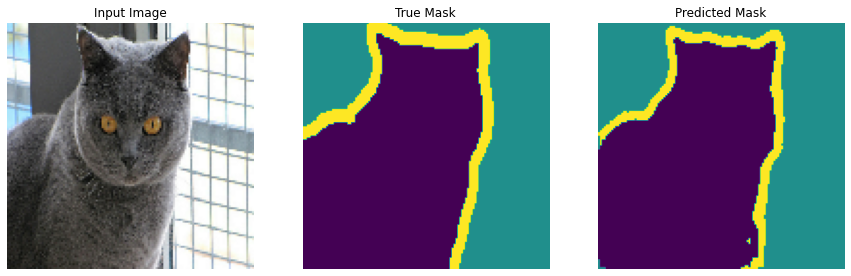

In [ ]:
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]

def show_predictions(dataset=None, num=1):
 if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
 else:
   display([sample_image, sample_mask,
            create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)
show_predictions()